In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import ClusterCentroids
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [39]:
treino = pd.read_csv("train.csv")
teste = pd.read_csv("test.csv")

treino = treino.drop(columns=['nome', 'sequencial_candidato'])
teste = teste.drop(columns=['nome', 'sequencial_candidato'])

In [40]:
numeric_feats = treino.dtypes[treino.dtypes != "object"].index

numeric_feats = numeric_feats.drop('ano')
numeric_feats = numeric_feats.drop('situacao')

treino[numeric_feats] = np.log1p(treino[numeric_feats])

teste[numeric_feats] = np.log1p(teste[numeric_feats])

In [41]:
allData = pd.concat((teste,treino), sort=False)

teste = allData.loc[:,:'ocupacao']
teste = pd.get_dummies(teste)

treino_X = teste.loc[teste['ano'] != 2014]
teste = teste.loc[teste['ano'] == 2014]

treino_Y = allData.loc[allData['ano'] != 2014]
treino_Y = treino_Y.loc[:,'situacao']

In [42]:
treino_X = treino.loc[:,:'ocupacao']
treino_Y = treino.loc[:,'situacao']

In [43]:
treino_X = pd.get_dummies(treino_X)
teste = pd.get_dummies(teste)

## 1) Há desbalanceamento das classes? Em que proporção? 

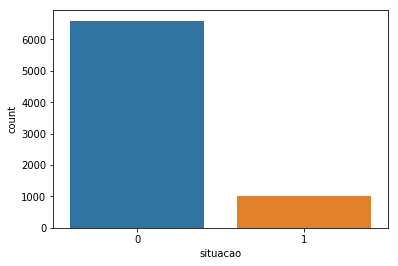

In [44]:
sns.countplot(treino_Y)

É clara a diferença entre a quantidade de instâncias da classe nao_eleito e eleito. Isso pode levar o modelo a aprender de forma errada, pois pode deixar o modelo enviesado, classificando as instâncias como sendo da classe majoritária.

Para balancear as classes usarei a técnica de under-sampling, cluser centroids.

In [ ]:
cc = ClusterCentroids()
x_cc, y_cc = cc.fit_sample(treino_X, treino_Y)
y_cc = y_cc[:,np.newaxis]

sns.countplot(y_cc[:,0])

Com a mesma quantidade de instâncias entre as duas classes, a chance de o modelo sofrer de underfiting é bem menor.

In [ ]:
data = np.concatenate((x_cc, y_cc), axis=1)
data = np.random.permutation(data)
x_cc = data[:,0:-1]
y_cc = data[:,-1]
y_cc = y_cc.astype('int')

Para melhorar a validação dos modelos, utilizo uma função para fazer uma permutação aleatória nos dados, pois esses ficam agrupados na saída da função de cluster centroids.

In [ ]:
treino_X = np.array(treino_X)
treino_Y = np.array(treino_Y)

Alterei o tipo do data frame para array, para a função de report funcionar apropriadamente.

In [29]:
def cv_report2(model, predictors, outcome, nfolds):
    
    kf = KFold(n_splits=nfolds)
    
    precision = [[],[]]
    recall = [[],[]]
    f1_score = [[],[]]
    
    for train, validation in kf.split(predictors):
        train_predictors = (predictors[train,:])
        train_target =  outcome[train]
        model.fit(train_predictors, train_target)
        
        predTrain = model.predict(predictors[train,:])
        report = metrics.classification_report(outcome[train], predTrain, output_dict=True)
        precision[0].append(report['1']['precision'])
        recall[0].append(report['1']['recall'])
        f1_score[0].append(report['1']['f1-score'])
        
        predVal = model.predict(predictors[validation,:])
        report = metrics.classification_report(outcome[validation], predVal, output_dict=True)
        precision[1].append(report['1']['precision'])
        recall[1].append(report['1']['recall'])
        f1_score[1].append(report['1']['f1-score'])
        
    retorno = [[],[]]
    retorno[0] = [np.mean(precision[0]),np.mean(recall[0]),np.mean(f1_score[0])]
    retorno[1] = [np.mean(precision[1]),np.mean(recall[1]),np.mean(f1_score[1])]
    return retorno

In [16]:
def validation_report(model, validationX, validationY):
    
    predVal = model.predict(validationX)
    report = metrics.classification_report(validationY, predVal, output_dict=True)
    
    return [report["1"]["precision"],report["1"]["recall"],report["1"]["f1-score"]]

In [30]:
def cv_report(model, predictors, outcome, nfolds):
    
    kf = KFold(n_splits=nfolds)
    f1_score = []
    
    for train, validation in kf.split(predictors):
        train_predictors = (predictors[train,:])
        train_target =  outcome[train]
        model.fit(train_predictors, train_target)
        
        predVal = model.predict(predictors[validation,:])
        report = metrics.classification_report(outcome[validation], predVal, output_dict=True)
        f1_score.append(report['1']['f1-score'])

    return np.mean(f1_score)

Função que retorna o precision, recall e F1, no treino e na validação. Os calculos são referentes apenas à variável eleito.

In [12]:
def real_f1(model):
    return metrics.classification_report(treino_Y, model.predict(treino_X), output_dict=True)['1']['f1-score']

Função que testa um modelo com todos os dados de 2006 e 2010, e retorna o F1 de um modelo para todos os dados.

In [13]:
def report_full(model,trainX, trainY, n):
    model.fit(trainX, trainY)
    return real_f1(model)

Treina o modelo com alguns dados e chama a função real_f1 para testar o modelo com todos os dados.

## 2) Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost.

Os modelos a seguir serão treinados com e sem os dados balanceados, para comparar o desempenho de cada um.

## Regressão Logística

### Dados não balanceados

In [31]:
lambdas = np.arange(0.01,2,0.01).tolist()

In [32]:
cv_logRegUnbalanced = [cv_report(LogisticRegression(solver="lbfgs", max_iter=10000, C=lbd, random_state=1), treino_X, treino_Y, 5)
            for lbd in lambdas]

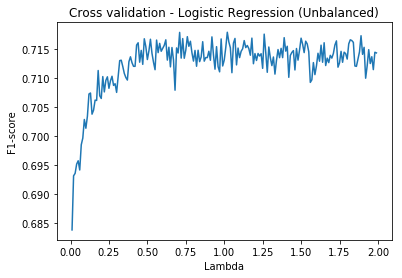

O melhor alpha é 1.02, com F1 = 0.7179456293598359


In [34]:
cv_logRegUnbalanced = pd.Series(cv_logRegUnbalanced, index = lambdas)

cv_logRegUnbalanced.plot(title = "Cross validation - Logistic Regression (Unbalanced)")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()

print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegUnbalanced.idxmax(), cv_logRegUnbalanced.max()))

### Dados balanceados

In [37]:
cv_logRegBalanced = [cv_report(LogisticRegression(solver="lbfgs", max_iter=10000, C=lbd, random_state=1), x_cc, y_cc, 5)
            for lbd in lambdas]
cv_logRegBalanced = pd.Series(cv_logRegBalanced, index = lambdas)

KeyError: '1'

In [36]:
cv_logRegBalanced.plot(title = "Cross validation - Logistic Regression (Balanced)")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()

print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegBalanced.idxmax(), cv_logRegBalanced.max()))

NameError: name 'cv_logRegBalanced' is not defined

In [43]:
lgModel = LogisticRegression(solver="lbfgs", max_iter=10000, C=cv_logRegBalanced.idxmax(), random_state=1)
lgModel.fit(x_cc,y_cc)

print("O F1 do modelo para todos os dados é {0}".format(real_f1(lgModel)))

O F1 do modelo para todos os dados é 0.9061926003673576


## KNN

### Dados não balanceados

In [32]:
k_list = np.arange(1,100,1).tolist()

In [33]:
cv_knnUnbalanced = [cv_report(KNeighborsClassifier(n_neighbors = n), treino_X, treino_Y, 5).mean()
            for n in k_list]

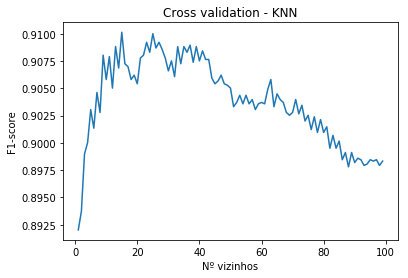

O melhor lambda é 15, com F1-score = 0.9101321801987867


In [34]:
cv_knnUnbalanced = pd.Series(cv_knnUnbalanced, index = k_list)
cv_knnUnbalanced.plot(title = "Cross validation - KNN (Unbalanced)")
plt.xlabel("Nº vizinhos")
plt.ylabel("F1-score")
plt.show()

print("O melhor lambda é {0}, com F1-score = {1}".format(cv_knnUnbalanced.idxmax(), cv_knnUnbalanced.max()))

### Dados balanceados

In [50]:
cv_knnBalanced = [cv_report1(KNeighborsClassifier(n_neighbors = n), x_cc, y_cc, 5)
            for n in k_list]

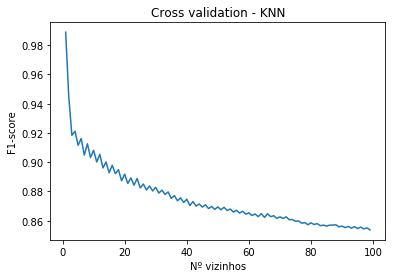

O melhor lambda é 1, com F1-score = 0.9888480713723432


In [51]:
cv_knnBalanced = pd.Series(cv_knnBalanced, index = k_list)
cv_knnBalanced.plot(title = "Cross validation - KNN (Balanced)")
plt.xlabel("Nº vizinhos")
plt.ylabel("F1-score")
plt.show()

print("O melhor lambda é {0}, com F1-score = {1}".format(cv_knnBalanced.idxmax(), cv_knnBalanced.max()))

In [56]:
knnModel = KNeighborsClassifier(n_neighbors=cv_knnBalanced.idxmax())
knnModel.fit(x_cc,y_cc)

print("O F1 do modelo para todos os dados é {0}".format(real_f1(knnModel)))

O F1 do modelo para todos os dados é 0.9888480713723432


## Decision tree

### Dados não balanceados

In [87]:
depth_list = np.arange(1,100,1).tolist()

In [18]:
cv_treeUnbalanced = [cv_report(DecisionTreeClassifier(max_depth=depth), treino_X, treino_Y, 5).mean()
            for depth in depth_list]

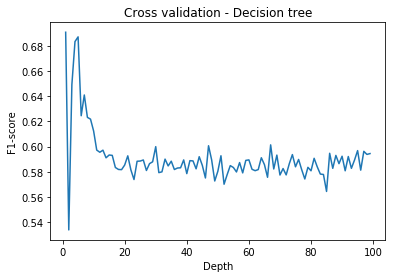

O melhor lambda é 1, com F1-score = 0.6908711885676002


In [19]:
cv_treeUnbalanced = pd.Series(cv_treeUnbalanced, index = depth_list)
cv_treeUnbalanced.plot(title = "Cross validation - Decision tree (Unbalanced)")
plt.xlabel("Depth")
plt.ylabel("F1-score")
plt.show()

print("O melhor lambda é {0}, com F1-score = {1}".format(cv_treeUnbalanced.idxmax(), cv_treeUnbalanced.max()))

### Dados balanceados

In [88]:
cv_treeBalanced = [cv_report(DecisionTreeClassifier(max_depth=depth), x_cc, y_cc, 5).mean()
            for depth in depth_list]

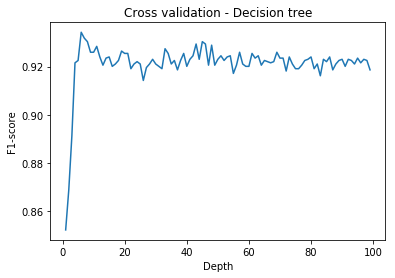

O melhor lambda é 6, com F1-score = 0.9342056851225446


In [89]:
cv_treeBalanced = pd.Series(cv_treeBalanced, index = depth_list)
cv_treeBalanced.plot(title = "Cross validation - Decision tree (Balanced)")
plt.xlabel("Depth")
plt.ylabel("F1-score")
plt.show()

print("A melhor profundidade é {0}, com F1-score = {1}".format(cv_treeBalanced.idxmax(), cv_treeBalanced.max()))

In [91]:
decTree = DecisionTreeClassifier(max_depth=cv_treeBalanced.idxmax())
decTree.fit(x_cc,y_cc)

print("O F1 do modelo para todos os dados é {0}".format(real_f1(decTree)))

O F1 do modelo para todos os dados é 0.8067436368407243


## Adaboost

### Dados não balanceados

In [ ]:
estimators = np.arange(1,50,1).tolist()
cv_adaBoost =  [cv_report(AdaBoostClassifier(algorithm="SAMME.R", n_estimators=estimator)).mean()
            for estimator in estimators]

cv_adaBoost = pd.Series(cv_adaBoost, index = estimators)

cv_ada.plot(title = "Cross validation - Adaboost")
plt.xlabel("Nº estimator")
plt.ylabel("F1-score")
print("A quantidade de estimators ideal é {0}, com F1 = {1}".format(cv_ada.idxmax(), cv_ada.max()))

### Dados balanceados

In [ ]:
estimators = np.arange(1,50,1).tolist()
cv_adaBoost =  [cv_report(AdaBoostClassifier(algorithm="SAMME.R", n_estimators=estimator)).mean()
            for estimator in estimators]

cv_adaBoost = pd.Series(cv_adaBoost, index = estimators)


cv_ada.plot(title = "Cross validation - Adaboost")
plt.xlabel("Nº estimator")
plt.ylabel("F1-score")
print("A quantidade de estimators ideal é {0}, com F1 = {1}".format(cv_ada.idxmax(), cv_ada.max()))

## Random forest

In [57]:
depth_list = np.arange(1,100,1).tolist()

cv_forest = [cv_report(RandomForestClassifier(max_depth = max_depth, n_estimators=70, random_state=7, class_weight="balanced_subsample"), treino_X, treino_Y, 5).mean()
            for max_depth in depth_list]

/home/renato/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/renato/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/renato/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/renato/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

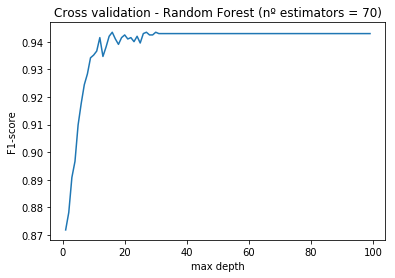

A melhor profundidade (para estimators=100) é 16, com F1 = 0.9434585484540976


In [99]:
cv_forest = pd.Series(cv_forest, index = depth_list)
cv_forest.plot(title = "Cross validation - Random Forest (nº estimators = 70)")
plt.xlabel("max depth")
plt.ylabel("F1-score")
plt.show()

print("A melhor profundidade (para estimators=70) é {0}, com F1 = {1}".format(cv_forest.idxmax(), cv_forest.max()))

In [100]:
estimators_list = np.arange(10,500,10).tolist()

cv_forest_dpMin = [f1_cv(RandomForestClassifier(max_depth = cv_forest.idxmax(), n_estimators = n_estimators, random_state=7, class_weight="balanced_subsample"), treino_X, treino_X, 5).mean()
            for n_estimators in estimators_list]

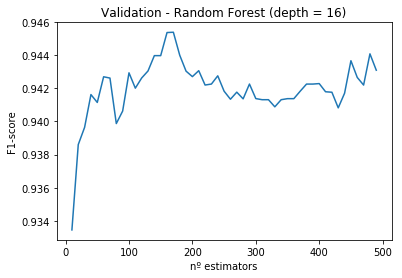

O melhor número de estimators (para profundidade=16) é 170, com F1 = 0.9453795023820757


In [101]:
cv_forest_dpMin = pd.Series(cv_forest_dpMin, index = estimators_list)
cv_forest_dpMin.plot(title = "Validation - Random Forest (depth = {0})".format(cv_forest.idxmax()))
plt.xlabel("nº estimators")
plt.ylabel("F1-score")
plt.show()

print("O melhor número de estimators (para profundidade={0}) é {1}, com F1 = {2}".format(cv_forest.idxmax(), cv_forest_dpMin.idxmax(), cv_forest_dpMin.max()))

In [102]:
rdForest = RandomForestClassifier(max_depth=cv_forest.idxmax(), n_estimators=cv_forest_dpMin.idxmax(), random_state=7)
rdForest.fit(x_cc,y_cc)

print("O F1 do modelo para todos os dados é {0}".format(real_f1(rdForest)))

O F1 do modelo para todos os dados é 0.8588297034898976


## Dados de envio

In [47]:
lgModel = LogisticRegression(solver="lbfgs", max_iter=10000, C=1.69, random_state=1)
lgModel.fit(x_cc,y_cc)


predictions = lgModel.predict(teste)

In [61]:
rdForest = RandomForestClassifier(max_depth=26, n_estimators=100, random_state=7)
rdForest.fit(x_cc,y_cc)

predictions = rdForest.predict(teste)

In [52]:
knnModel = KNeighborsClassifier(n_neighbors=1)
knnModel.fit(treino_X,treino_Y)

predictions = knnModel.predict(teste)

In [53]:
envio = pd.read_csv("sample_submission.csv")

envio["Predicted"] = predictions
envio["Predicted"] = envio["Predicted"].replace([0, 1],['nao_eleito', 'eleito'])

In [55]:
envio.to_csv("Envio.csv", index=False)